In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix



In [7]:
from google.colab import files
uploaded = files.upload()



Saving Online Retail.xlsx to Online Retail.xlsx


In [10]:
from openpyxl import load_workbook

# Load the Excel file
wb = load_workbook('/content/Online Retail.xlsx')

# Assuming the first sheet contains the data
sheet = wb.active

# Display the first few rows of data
for row in sheet.iter_rows(min_row=1, max_row=5, values_only=True):
    print(row)


('InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country')
(536365, '85123A', 'WHITE HANGING HEART T-LIGHT HOLDER', 6, datetime.datetime(2010, 12, 1, 8, 26), 2.55, 17850, 'United Kingdom')
(536365, 71053, 'WHITE METAL LANTERN', 6, datetime.datetime(2010, 12, 1, 8, 26), 3.39, 17850, 'United Kingdom')
(536365, '84406B', 'CREAM CUPID HEARTS COAT HANGER', 8, datetime.datetime(2010, 12, 1, 8, 26), 2.75, 17850, 'United Kingdom')
(536365, '84029G', 'KNITTED UNION FLAG HOT WATER BOTTLE', 6, datetime.datetime(2010, 12, 1, 8, 26), 3.39, 17850, 'United Kingdom')


In [11]:
missing_values_count = 0

# Iterate over rows and columns to count missing values
for row in sheet.iter_rows(values_only=True):
    for cell in row:
        if cell is None:
            missing_values_count += 1

# Display the total number of missing values
print("Total missing values:", missing_values_count)

Total missing values: 136534


In [14]:
import pandas as pd

# Load the data into a DataFrame (replace '/path/to/your/data.xlsx' with your actual file path)
df = pd.read_excel('/content/Online Retail.xlsx')

# Now you can proceed with handling missing values or other data preprocessing tasks


In [15]:
# Drop rows with missing values in 'InvoiceNo', 'StockCode', 'Description' columns
df.dropna(subset=['InvoiceNo', 'StockCode', 'Description'], inplace=True)

# Impute missing values in 'Quantity', 'UnitPrice' columns with mean
df['Quantity'].fillna(df['Quantity'].mean(), inplace=True)
df['UnitPrice'].fillna(df['UnitPrice'].mean(), inplace=True)

# Impute missing values in 'InvoiceDate' column with mode (most frequent date)
df['InvoiceDate'].fillna(df['InvoiceDate'].mode()[0], inplace=True)

# Impute missing values in 'CustomerID' column with a placeholder value
df['CustomerID'].fillna('Unknown', inplace=True)

# Impute missing values in 'Country' column with the most frequent country
df['Country'].fillna(df['Country'].mode()[0], inplace=True)


In [16]:
import pandas as pd

# Assuming 'InvoiceDate', 'CustomerID', 'Quantity', and 'UnitPrice' columns exist
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Define the fixed date range
start_date = pd.Timestamp('2010-12-01 08:26')
end_date = pd.Timestamp('2011-12-09 12:50')

# Calculate Recency, Frequency, Monetary metrics for each customer
rfm_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (end_date - x.max()).days,  # Recency based on the fixed date range
    'InvoiceNo': 'count',  # Frequency
    'TotalPrice': 'sum'  # Monetary
}).reset_index()

# Rename columns for clarity
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

# Assign RFM scores
rfm_df['RecencyScore'] = pd.qcut(rfm_df['Recency'], q=5, labels=range(5, 0, -1))
rfm_df['FrequencyScore'] = pd.qcut(rfm_df['Frequency'], q=5, labels=range(1, 6))
rfm_df['MonetaryScore'] = pd.qcut(rfm_df['Monetary'], q=5, labels=range(1, 6))

# Combine RFM scores into a single RFM segment
rfm_df['RFM_Segment'] = rfm_df['RecencyScore'].astype(str) + rfm_df['FrequencyScore'].astype(str) + rfm_df['MonetaryScore'].astype(str)

# RFM analysis
# Example: Display the top 10 customers in each RFM segment
rfm_df.sort_values(by='RFM_Segment').groupby('RFM_Segment').head(10)


,CustomerID,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Segment
0,12346.0,325,2,0.00,1,1,1,111
2293,15447.0,330,9,155.17,1,1,1,111
3561,17174.0,217,4,59.90,1,1,1,111
4194,18048.0,202,7,172.29,1,1,1,111
4195,18050.0,358,5,74.40,1,1,1,111
...,...,...,...,...,...,...,...,...
205,12598.0,9,133,3002.68,5,5,5,555
330,12748.0,0,4642,29072.10,5,5,5,555
261,12662.0,0,232,3817.08,5,5,5,555
105,12476.0,0,264,6546.58,5,5,5,555


In [17]:
# Drop customers with Monetary value lesser than 100
rfm_df = rfm_df[rfm_df['Monetary'] >= 100]

# Print the updated DataFrame
print(rfm_df)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  # Import KMeans from sklearn.cluster

# Standardize the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze cluster characteristics
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()

print(cluster_summary)


     CustomerID  Recency  Frequency    Monetary RecencyScore FrequencyScore  \
1       12347.0        1        182     4310.00            5              5   
2       12348.0       74         31     1797.24            2              3   
3       12349.0       18         73     1757.55            4              4   
4       12350.0      309         17      334.40            1              2   
5       12352.0       35         95     1545.41            3              4   
...         ...      ...        ...         ...          ...            ...   
4367    18280.0      277         10      180.60            1              1   
4369    18282.0        7         13      176.60            5              1   
4370    18283.0        3        756     2094.88            5              5   
4371    18287.0       42         70     1837.28            3              4   
4372    Unknown        0     133626  1447682.12            5              5   

     MonetaryScore RFM_Segment  
1                5

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   Cluster     Recency      Frequency      Monetary  CustomerID
0        0   29.756149     125.754743  2.622083e+03        2846
1        1    0.000000  133626.000000  1.447682e+06           1
2        2  150.319683      43.509908  7.684243e+02         757
3        3  291.247292      26.166065  4.661040e+02         554


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score  # Import silhouette_score

# Standardize the RFM metrics
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Analyze cluster characteristics
cluster_summary = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()

print(cluster_summary)

# Predict the cluster labels for each data point
cluster_labels = kmeans.predict(rfm_scaled)

# Calculate the silhouette score
silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)

print("The silhouette score is:", silhouette_avg)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


   Cluster     Recency      Frequency      Monetary  CustomerID
0        0  291.247292      26.166065  4.661040e+02         554
1        1  150.319683      43.509908  7.684243e+02         757
2        2    0.000000  133626.000000  1.447682e+06           1
3        3    6.666667    1828.333333  1.821820e+05           6
4        4   29.804930     122.157746  2.242731e+03        2840
The silhouette score is: 0.6404224671847889


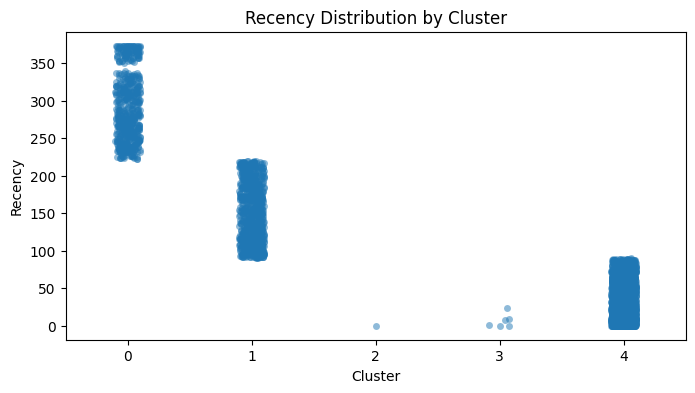

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the size of the plot
plt.figure(figsize=(8, 4))

# Create a strip plot (dot plot) for Recency distribution by Cluster
sns.stripplot(data=rfm_df, x='Cluster', y='Recency', jitter=True, alpha=0.5)

# Set the title and labels
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Recency')

# Show the plot
plt.show()


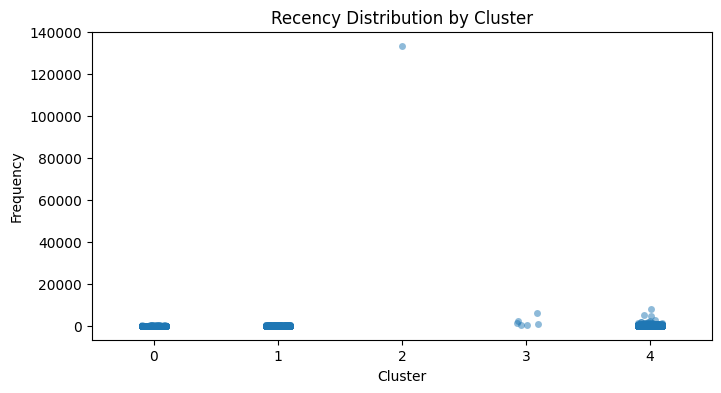

In [24]:
# Set the size of the plot
plt.figure(figsize=(8, 4))

# Create a strip plot (dot plot) for Recency distribution by Cluster
sns.stripplot(data=rfm_df, x='Cluster', y='Frequency', jitter=True, alpha=0.5)

# Set the title and labels
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Frequency')

# Show the plot
plt.show()


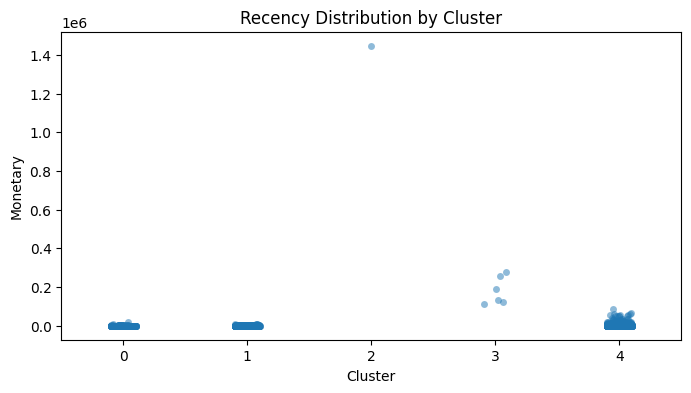

In [26]:
# Set the size of the plot
plt.figure(figsize=(8, 4))

# Create a strip plot (dot plot) for Recency distribution by Cluster
sns.stripplot(data=rfm_df, x='Cluster', y='Monetary', jitter=True, alpha=0.5)

# Set the title and labels
plt.title('Recency Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Monetary')

# Show the plot
plt.show()
